Description:  In this notebook we will load saved pre-trained models and compare and evaluate results, and determine next steps.

In [ ]:
import os
import zipfile
import pandas as pd
import shutil
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from sklearn.preprocessing import label_binarize

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_dir = 'drive/MyDrive/Colab Notebooks/data_mining'
filename = 'liar_dataset.zip'

# Define file paths
zip_path = os.path.join(base_dir, filename)
extract_path = os.path.join(base_dir, "liar_dataset")

# Step 2: Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Dataset extracted to: {extract_path}")

Dataset extracted to: drive/MyDrive/Colab Notebooks/data_mining/liar_dataset


In [ ]:
# Load training, validation, and test datasets into DataFrames
train_path = os.path.join(extract_path, "train.tsv")
valid_path = os.path.join(extract_path, "valid.tsv")
test_path = os.path.join(extract_path, "test.tsv")

# Define column names based on the dataset structure
columns = [
    "id", "label", "statement", "subject", "speaker", "job",
    "state", "party", "barely_true", "false",
    "half_true", "mostly_true", "pants_on_fire", "context"
]

# Load datasets
train_df = pd.read_csv(train_path, sep='\t', header=None, names=columns)
valid_df = pd.read_csv(valid_path, sep='\t', header=None, names=columns)
test_df = pd.read_csv(test_path, sep='\t', header=None, names=columns)

print("Datasets loaded successfully!")

Datasets loaded successfully!


In [ ]:
# Check the shape of the datasets
print(f"Train Dataset: {train_df.shape}")
print(f"Validation Dataset: {valid_df.shape}")
print(f"Test Dataset: {test_df.shape}")

# Display the first few rows of the training dataset
print("Sample rows from the training dataset:")
print(train_df.head())

# Check for missing values
print("\nMissing values in the training dataset:")
print(train_df.isnull().sum())

# Analyze label distribution
print("\nLabel distribution in the training dataset:")
print(train_df["label"].value_counts())


Train Dataset: (10240, 14)
Validation Dataset: (1284, 14)
Test Dataset: (1267, 14)
Sample rows from the training dataset:
           id        label                                          statement  \
0   2635.json        false  Says the Annies List political group supports ...   
1  10540.json    half-true  When did the decline of coal start? It started...   
2    324.json  mostly-true  Hillary Clinton agrees with John McCain "by vo...   
3   1123.json        false  Health care reform legislation is likely to ma...   
4   9028.json    half-true  The economic turnaround started at the end of ...   

                              subject         speaker                   job  \
0                            abortion    dwayne-bohac  State representative   
1  energy,history,job-accomplishments  scott-surovell        State delegate   
2                      foreign-policy    barack-obama             President   
3                         health-care    blog-posting                   NaN

In [ ]:
!pip install datasets
# !pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 w

In [ ]:
import torch
from transformers import AutoTokenizer
from torch.utils.data import DataLoader, Dataset as TorchDataset
from datasets import Dataset
from sklearn.preprocessing import OneHotEncoder

# Map labels to numerical values
label_map = {"pants-fire": 0, "false": 1, "barely-true": 2, "half-true": 3, "mostly-true": 4, "true": 5}
train_df["label"] = train_df["label"].map(label_map)
valid_df["label"] = valid_df["label"].map(label_map)
test_df["label"] = test_df["label"].map(label_map)

# One-hot encode 'speaker' and 'party' (Fit on train, Transform on valid and test)
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")

train_metadata = encoder.fit_transform(train_df[["speaker", "party"]])
valid_metadata = encoder.transform(valid_df[["speaker", "party"]])
test_metadata = encoder.transform(test_df[["speaker", "party"]])

# Load tokenizer for BERT/RoBERTa
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_text(text):
    """Tokenizes input text and returns input_ids and attention_mask."""
    encodings = tokenizer(text, padding="max_length", truncation=True, max_length=512, return_tensors="pt")
    return encodings["input_ids"].squeeze(0), encodings["attention_mask"].squeeze(0)

# Apply tokenization to each dataset
train_tokenized = train_df["statement"].apply(tokenize_text)
valid_tokenized = valid_df["statement"].apply(tokenize_text)
test_tokenized = test_df["statement"].apply(tokenize_text)

# Extract input_ids and attention_mask separately
train_df["input_ids"], train_df["attention_mask"] = zip(*train_tokenized)
valid_df["input_ids"], valid_df["attention_mask"] = zip(*valid_tokenized)
test_df["input_ids"], test_df["attention_mask"] = zip(*test_tokenized)

# Convert metadata to list format
train_metadata = train_metadata.tolist()
valid_metadata = valid_metadata.tolist()
test_metadata = test_metadata.tolist()

# Extract labels
train_labels = train_df["label"].tolist()
valid_labels = valid_df["label"].tolist()
test_labels = test_df["label"].tolist()

# Create dataset dictionaries
train_data = [{"input_ids": text, "attention_mask": mask, "metadata": meta, "label": label}
              for text, mask, meta, label in zip(train_df["input_ids"], train_df["attention_mask"], train_metadata, train_labels)]

valid_data = [{"input_ids": text, "attention_mask": mask, "metadata": meta, "label": label}
              for text, mask, meta, label in zip(valid_df["input_ids"], valid_df["attention_mask"], valid_metadata, valid_labels)]

test_data = [{"input_ids": text, "attention_mask": mask, "metadata": meta, "label": label}
             for text, mask, meta, label in zip(test_df["input_ids"], test_df["attention_mask"], test_metadata, test_labels)]

# Convert to Hugging Face dataset format
train_dataset = Dataset.from_list(train_data)
valid_dataset = Dataset.from_list(valid_data)
test_dataset = Dataset.from_list(test_data)

print("Data Preprocessing Complete")

# Convert Hugging Face dataset to PyTorch Dataset for Dataloader
class LIARDataset(TorchDataset):
    def __init__(self, hf_dataset, use_metadata=False):
        self.dataset = hf_dataset
        self.use_metadata = use_metadata  # Control whether metadata is used

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        data_dict = {
            "input_ids": torch.tensor(item["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(item["attention_mask"], dtype=torch.long),
            "labels": torch.tensor(item["label"], dtype=torch.long),
        }

        if self.use_metadata:
            data_dict["metadata"] = torch.tensor(item["metadata"], dtype=torch.float)

        return data_dict

# Create DataLoader for test set
test_torch_dataset = LIARDataset(test_dataset, use_metadata=False)  # Set to True if metadata is needed
test_dataloader = DataLoader(test_torch_dataset, batch_size=16, shuffle=False)

print("Test DataLoader Ready")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Data Preprocessing Complete
Test DataLoader Ready


In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load the saved model
model_path = os.path.join(base_dir, "bert_model")
bert_model = AutoModelForSequenceClassification.from_pretrained(model_path)
bert_tokenizer = AutoTokenizer.from_pretrained(model_path)


In [ ]:
def evaluate_model(model, dataloader, device, num_classes=6):
    model.to(device)
    model.eval()

    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask)
            probs = torch.nn.functional.softmax(outputs.logits, dim=1)  # Convert logits to probabilities
            preds = torch.argmax(probs, dim=1)

            # Debug
            # print("Sample Logits:", outputs.logits[:5])
            # break


            # Move tensors back to CPU
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())  # Store probabilities for AUC

    # Compute accuracy, precision, recall, and F1
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="weighted")

    # One-hot encode labels for multi-class AUC
    all_labels_one_hot = label_binarize(all_labels, classes=np.arange(num_classes))

    try:
        auc_roc = roc_auc_score(all_labels_one_hot, all_probs, multi_class="ovo")
    except ValueError:
        auc_roc = float("nan")  # Handle case where only one class is predicted

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")

    return accuracy, precision, recall, f1, auc_roc, all_preds, all_labels, all_probs

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_results = evaluate_model(bert_model, test_dataloader, device)
bert_results_dict = {
    "Model": "BERT",
    "Accuracy": bert_results[0],
    "Precision": bert_results[1],
    "Recall": bert_results[2],
    "F1-Score": bert_results[3],
    "AUC-ROC": bert_results[4],
}

Accuracy: 0.2715
Precision: 0.2751, Recall: 0.2715, F1-Score: 0.2642
AUC-ROC: 0.6409


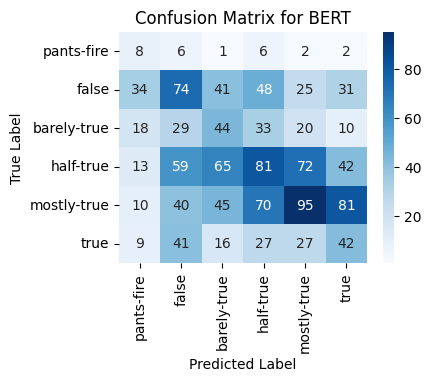

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_map.keys(), yticklabels=label_map.keys())
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

plot_confusion_matrix(bert_results[5], bert_results[6], title="Confusion Matrix for BERT")


Next steps:
- Load saved Hybrid Model, evaluate
- Load saved MC Hybrid Model, evaluate

- How can we improve?
  - BERT currently does not handle imbalanced dataset, train with weights, etc.
  - Other fine-tuning for Hybrid or Hybrid MC, pick one for final fine-tuning.

- Document and update reports.

Process Data for Hybrid and Hybrid MC Models

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset as TorchDataset
from transformers import AutoModel, AutoTokenizer
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Load datasets
train_df = pd.read_csv(train_path, sep='\t', header=None, names=columns)
valid_df = pd.read_csv(valid_path, sep='\t', header=None, names=columns)
test_df = pd.read_csv(test_path, sep='\t', header=None, names=columns)

# Drop rows with missing "speaker" and "party".
train_df.dropna(subset=["speaker", "party"], inplace=True)
valid_df.dropna(subset=["speaker", "party"], inplace=True)
test_df.dropna(subset=["speaker", "party"], inplace=True)

# Map labels to numeric values
label_map = {"pants-fire": 0, "false": 1, "barely-true": 2, "half-true": 3, "mostly-true": 4, "true": 5}
train_df["label"] = train_df["label"].map(label_map)
valid_df["label"] = valid_df["label"].map(label_map)
test_df["label"] = test_df["label"].map(label_map)

# One-hot encode metadata ('speaker' and 'party')
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
train_metadata = encoder.fit_transform(train_df[["speaker", "party"]])
valid_metadata = encoder.transform(valid_df[["speaker", "party"]])
test_metadata = encoder.transform(test_df[["speaker", "party"]])

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

def tokenize_text(text):
    """Tokenizes input text and returns input_ids and attention_mask."""
    encodings = tokenizer(text, padding="max_length", truncation=True, max_length=512, return_tensors="pt")
    return encodings["input_ids"].squeeze(0), encodings["attention_mask"].squeeze(0)

# Tokenize statements
train_tokenized = train_df["statement"].apply(tokenize_text)
valid_tokenized = valid_df["statement"].apply(tokenize_text)
test_tokenized = test_df["statement"].apply(tokenize_text)

# Extract input_ids and attention_mask
train_df["input_ids"], train_df["attention_mask"] = zip(*train_tokenized)
valid_df["input_ids"], valid_df["attention_mask"] = zip(*valid_tokenized)
test_df["input_ids"], test_df["attention_mask"] = zip(*test_tokenized)

# Convert metadata and labels to lists
train_metadata = train_metadata.tolist()
valid_metadata = valid_metadata.tolist()
test_metadata = test_metadata.tolist()

train_labels = train_df["label"].tolist()
valid_labels = valid_df["label"].tolist()
test_labels = test_df["label"].tolist()

# Create dataset class
class HybridDataset(TorchDataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        return {
            "input_ids": torch.tensor(item["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(item["attention_mask"], dtype=torch.long),
            "metadata": torch.tensor(item["metadata"], dtype=torch.float),
            "labels": torch.tensor(item["label"], dtype=torch.long)
        }

# Convert to dataset format
train_data = [{"input_ids": text, "attention_mask": mask, "metadata": meta, "label": label}
              for text, mask, meta, label in zip(train_df["input_ids"], train_df["attention_mask"], train_metadata, train_labels)]
valid_data = [{"input_ids": text, "attention_mask": mask, "metadata": meta, "label": label}
              for text, mask, meta, label in zip(valid_df["input_ids"], valid_df["attention_mask"], valid_metadata, valid_labels)]
test_data = [{"input_ids": text, "attention_mask": mask, "metadata": meta, "label": label}
             for text, mask, meta, label in zip(test_df["input_ids"], test_df["attention_mask"], test_metadata, test_labels)]

# Create PyTorch Dataset
train_dataset = HybridDataset(train_data)
valid_dataset = HybridDataset(valid_data)
test_dataset = HybridDataset(test_data)

# Create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
class HybridBERTModel(nn.Module):
    def __init__(self, num_metadata_features, num_labels=6):
        super(HybridBERTModel, self).__init__()
        self.bert = AutoModel.from_pretrained("roberta-base")
        self.text_fc = nn.Linear(768, 256)
        self.metadata_fc = nn.Linear(num_metadata_features, 128)
        self.classifier = nn.Linear(256 + 128, num_labels)

    def forward(self, input_ids, attention_mask, metadata_features):
        text_output = self.bert(input_ids=input_ids, attention_mask=attention_mask).pooler_output
        text_features = torch.relu(self.text_fc(text_output))
        metadata_features = torch.relu(self.metadata_fc(metadata_features))
        combined = torch.cat((text_features, metadata_features), dim=1)
        return self.classifier(combined)


In [ ]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from sklearn.preprocessing import label_binarize

def evaluate_hybrid(model, dataloader, device):
    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    num_classes = 6  # Define number of classes

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            metadata = batch["metadata"].to(device)  # Ensure metadata is correctly handled
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask, metadata)

            # Ensure outputs contain logits
            logits = outputs.logits if hasattr(outputs, "logits") else outputs
            probs = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()  # Convert logits to probabilities
            preds = np.argmax(probs, axis=1)  # Convert probabilities to class predictions

            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs)  # Store probabilities for AUC-ROC calculation

    # Compute accuracy
    accuracy = accuracy_score(all_labels, all_preds)

    # Compute Precision, Recall, F1-score (weighted to handle class imbalance)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="weighted")

    # One-hot encode labels for multi-class AUC-ROC
    all_labels_one_hot = label_binarize(all_labels, classes=np.arange(num_classes))

    # Compute AUC-ROC
    try:
        auc_roc = roc_auc_score(all_labels_one_hot, np.array(all_probs), multi_class="ovo")
    except ValueError:
        auc_roc = float("nan")  # Handle case where only one class is predicted

    # Print results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")

    return accuracy, precision, recall, f1, auc_roc, all_preds, all_labels


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model with correct metadata input size
# num_metadata_features = 10  # ⚠️ Update this based on your dataset's metadata size
num_metadata_features = 2933 #train_metadata.shape[1]  # Gets total one-hot encoded feature count
print(f"Metadata Feature Count: {num_metadata_features}")
hybrid_model = HybridBERTModel(num_metadata_features=num_metadata_features).to(device)

# Load weights
hybrid_model.load_state_dict(torch.load(os.path.join(base_dir,"saved_models", "hybrid_model.pth"), map_location=device))
hybrid_model.eval()  # Set model to evaluation mode


Metadata Feature Count: 2933


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-17-8613ce87f62e>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recom

HybridBERTModel(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): La

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hybrid_results = evaluate_hybrid(hybrid_model, test_dataloader, device)

<ipython-input-14-39db6c3a3bc4>:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "input_ids": torch.tensor(item["input_ids"], dtype=torch.long),
<ipython-input-14-39db6c3a3bc4>:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "attention_mask": torch.tensor(item["attention_mask"], dtype=torch.long),


Accuracy: 0.2660
Precision: 0.2722, Recall: 0.2660, F1-Score: 0.2652
AUC-ROC: 0.6290


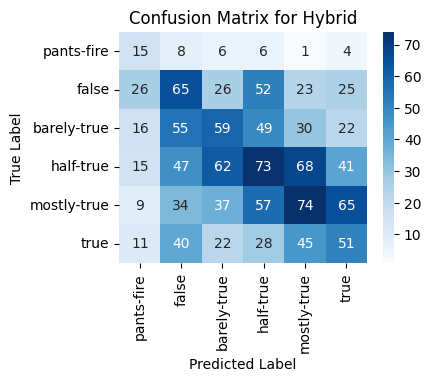

In [ ]:
hybrid_results_dict = {
    "Model": "hybrid",
    "Accuracy": hybrid_results[0],
    "Precision": hybrid_results[1],
    "Recall": hybrid_results[2],
    "F1-Score": hybrid_results[3],
    "AUC-ROC": hybrid_results[4],
}

plot_confusion_matrix(hybrid_results[5], hybrid_results[6], title="Confusion Matrix for Hybrid")

Load Hybrid MC Model

In [ ]:
# Define Hybrid Model with Monte Carlo Dropout
class HybridBERTModelMC(nn.Module):
    def __init__(self, num_metadata_features, num_labels=6, dropout_prob=0.3):
        super(HybridBERTModelMC, self).__init__()
        self.bert = AutoModel.from_pretrained("roberta-base")
        self.text_fc = nn.Linear(768, 256)
        self.metadata_fc = nn.Linear(num_metadata_features, 128)
        self.dropout = nn.Dropout(dropout_prob)  # 🔥 Dropout before classification
        self.classifier = nn.Linear(256 + 128, num_labels)

    def forward(self, input_ids, attention_mask, metadata_features):
        text_output = self.bert(input_ids=input_ids, attention_mask=attention_mask).pooler_output
        text_features = torch.relu(self.text_fc(text_output))
        metadata_features = torch.relu(self.metadata_fc(metadata_features))
        combined = torch.cat((text_features, metadata_features), dim=1)
        combined = self.dropout(combined)  # 🔥 Apply dropout even in inference
        return self.classifier(combined)

In [ ]:
num_metadata_features = 2933 #train_metadata.shape[1]  # Gets total one-hot encoded feature count
print(f"Metadata Feature Count: {num_metadata_features}")
hybridmc_model = HybridBERTModelMC(num_metadata_features=num_metadata_features).to(device)

# Load weights
hybridmc_model.load_state_dict(torch.load(os.path.join(base_dir,"saved_models", "hybrid_mc_dropout_model.pth"), map_location=device))
hybridmc_model.eval()  # Set model to evaluation mode

Metadata Feature Count: 2933


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-21-3125a663d8f0>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recomm

HybridBERTModelMC(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): 

In [ ]:
hybridmc_results = evaluate_hybrid(hybridmc_model, test_dataloader, device)

<ipython-input-14-39db6c3a3bc4>:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "input_ids": torch.tensor(item["input_ids"], dtype=torch.long),
<ipython-input-14-39db6c3a3bc4>:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "attention_mask": torch.tensor(item["attention_mask"], dtype=torch.long),


Accuracy: 0.2755
Precision: 0.2908, Recall: 0.2755, F1-Score: 0.2701
AUC-ROC: 0.6323


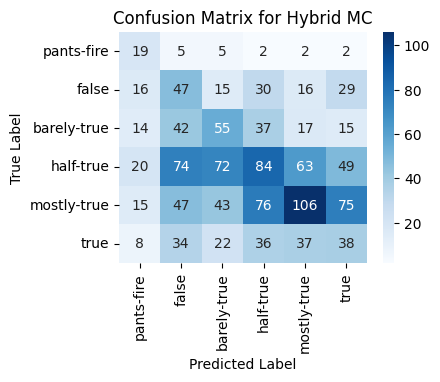

In [ ]:
hybridmc_results_dict = {
    "Model": "hybrid MC",
    "Accuracy": hybridmc_results[0],
    "Precision": hybridmc_results[1],
    "Recall": hybridmc_results[2],
    "F1-Score": hybridmc_results[3],
    "AUC-ROC": hybridmc_results[4],
}

plot_confusion_matrix(hybridmc_results[5], hybridmc_results[6], title="Confusion Matrix for Hybrid MC")

In [ ]:
hybridmc2_model = HybridBERTModelMC(num_metadata_features=num_metadata_features).to(device)

# Load weights
hybridmc2_model.load_state_dict(torch.load(os.path.join(base_dir,"saved_models", "hybrid_mc_dropout_model_r10.pth"), map_location=device))
hybridmc2_model.eval()  # Set model to evaluation mode

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-24-456ba6b88865>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recomm

HybridBERTModelMC(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): 

In [ ]:
hybridmc2_results = evaluate_hybrid(hybridmc2_model, test_dataloader, device)

<ipython-input-14-39db6c3a3bc4>:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "input_ids": torch.tensor(item["input_ids"], dtype=torch.long),
<ipython-input-14-39db6c3a3bc4>:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "attention_mask": torch.tensor(item["attention_mask"], dtype=torch.long),


Accuracy: 0.2565
Precision: 0.2641, Recall: 0.2565, F1-Score: 0.2461
AUC-ROC: 0.6132


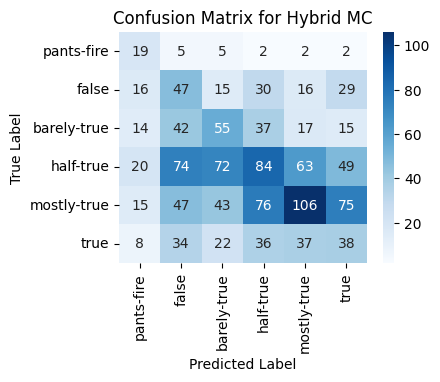

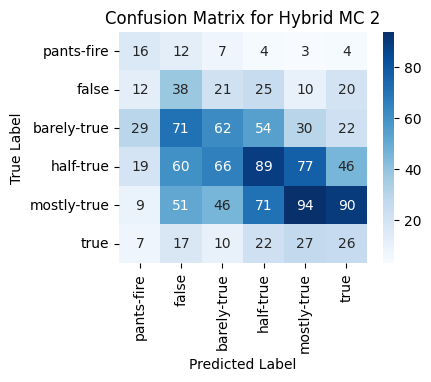

In [ ]:
hybridmc2_results_dict = {
    "Model": "hybrid MC2",
    "Accuracy": hybridmc2_results[0],
    "Precision": hybridmc2_results[1],
    "Recall": hybridmc2_results[2],
    "F1-Score": hybridmc2_results[3],
    "AUC-ROC": hybridmc2_results[4],
}
plot_confusion_matrix(hybridmc_results[5], hybridmc_results[6], title="Confusion Matrix for Hybrid MC")
plot_confusion_matrix(hybridmc2_results[5], hybridmc2_results[6], title="Confusion Matrix for Hybrid MC 2")

In [ ]:
df_results = pd.DataFrame([bert_results_dict, hybrid_results_dict , hybridmc_results_dict , hybridmc2_results_dict])
df_results

,Model,Accuracy,Precision,Recall,F1-Score,AUC-ROC
0,BERT,0.271507,0.275108,0.271507,0.264224,0.640883
1,hybrid,0.265983,0.272230,0.265983,0.265174,0.628954
2,hybrid MC,0.275454,0.290795,0.275454,0.270126,0.632290
3,hybrid MC2,0.256511,0.264067,0.256511,0.246079,0.613216


In [ ]:
base_dir

'drive/MyDrive/Colab Notebooks/data_mining'

In [ ]:
df_results.to_csv(os.path.join(base_dir, "results.csv"), index=False)

In [ ]:
print(df_results.to_markdown())

|    | Model      |   Accuracy |   Precision |   Recall |   F1-Score |   AUC-ROC |
|---:|:-----------|-----------:|------------:|---------:|-----------:|----------:|
|  0 | BERT       |   0.271507 |    0.275108 | 0.271507 |   0.264224 |  0.640883 |
|  1 | hybrid     |   0.265983 |    0.27223  | 0.265983 |   0.265174 |  0.628954 |
|  2 | hybrid MC  |   0.275454 |    0.290795 | 0.275454 |   0.270126 |  0.63229  |
|  3 | hybrid MC2 |   0.256511 |    0.264067 | 0.256511 |   0.246079 |  0.613216 |


### Compare results of tuned MC


In [ ]:
 #train_metadata.shape[1]  # Gets total one-hot encoded feature count
# print(f"Metadata Feature Count: {num_metadata_features}")
# mc_results_dict

In [ ]:
def load_mc_model(model_num):
    num_metadata_features = 2933
    model = HybridBERTModelMC(num_metadata_features=num_metadata_features).to(device)

    model.load_state_dict(torch.load(os.path.join(base_dir,"saved_models", f"hybrid_mc_model_best_r{model_num}.pth"), map_location=device))
    model.eval()  # Set model to evaluation mode
    model_results = evaluate_hybrid(model, test_dataloader, device)

    return model_results

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-32-67af2369ae88>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recomm

Accuracy: 0.2723
Precision: 0.2852, Recall: 0.2723, F1-Score: 0.2685
AUC-ROC: 0.6457


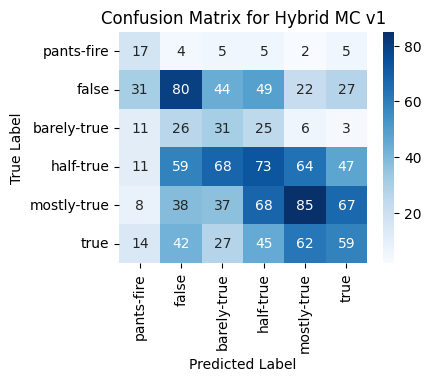

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-32-67af2369ae88>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recomm

Accuracy: 0.2715
Precision: 0.2768, Recall: 0.2715, F1-Score: 0.2695
AUC-ROC: 0.6363


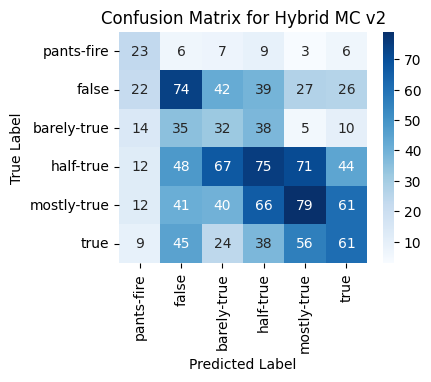

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-32-67af2369ae88>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recomm

Accuracy: 0.2818
Precision: 0.2907, Recall: 0.2818, F1-Score: 0.2805
AUC-ROC: 0.6240


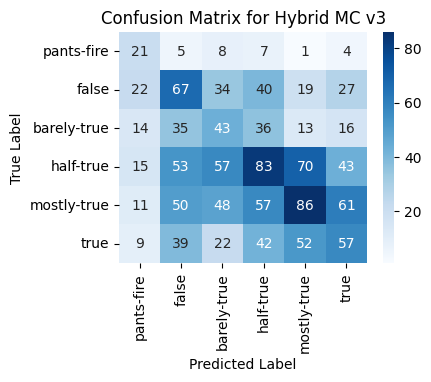

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-32-67af2369ae88>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recomm

Accuracy: 0.2691
Precision: 0.2811, Recall: 0.2691, F1-Score: 0.2685
AUC-ROC: 0.6186


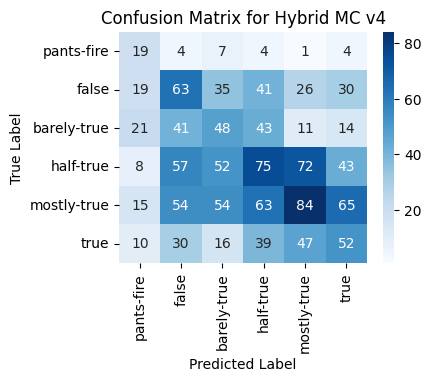

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-32-67af2369ae88>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recomm

Accuracy: 0.2660
Precision: 0.2691, Recall: 0.2660, F1-Score: 0.2629
AUC-ROC: 0.6077


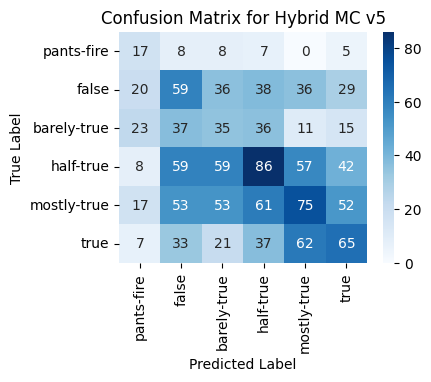

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-32-67af2369ae88>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recomm

Accuracy: 0.2723
Precision: 0.2804, Recall: 0.2723, F1-Score: 0.2686
AUC-ROC: 0.6087


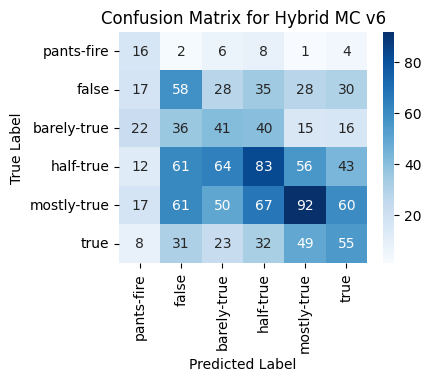

In [ ]:
mc_results_dict = {'Model':[],
                   'Accuracy':[],
                   'Precision':[],
                   'Recall':[],
                   'F1-Score':[],
                   'AUC-ROC':[]}
for num in range(1,7):
  mc_results = load_mc_model(num)
  mc_results_dict["Model"].append(f"Hybrid MC v{num}")
  mc_results_dict["Accuracy"].append(mc_results[0])
  mc_results_dict["Precision"].append(mc_results[1])
  mc_results_dict["Recall"].append(mc_results[2])
  mc_results_dict["F1-Score"].append(mc_results[3])
  mc_results_dict["AUC-ROC"].append(mc_results[4])

  plot_confusion_matrix(mc_results[5], mc_results[6], title=f"Confusion Matrix for Hybrid MC v{num}")


In [ ]:
final_results = pd.DataFrame(mc_results_dict)
final_results

,Model,Accuracy,Precision,Recall,F1-Score,AUC-ROC
0,Hybrid MC v1,0.272297,0.285157,0.272297,0.268520,0.645686
1,Hybrid MC v2,0.271507,0.276837,0.271507,0.269527,0.636330
2,Hybrid MC v3,0.281768,0.290664,0.281768,0.280525,0.623963
3,Hybrid MC v4,0.269140,0.281148,0.269140,0.268532,0.618581
4,Hybrid MC v5,0.265983,0.269056,0.265983,0.262853,0.607683
5,Hybrid MC v6,0.272297,0.280364,0.272297,0.268613,0.608669


In [ ]:
num_metadata_features = 2933
model = HybridBERTModelMC(num_metadata_features=num_metadata_features).to(device)

model.load_state_dict(torch.load(os.path.join(base_dir,"saved_models", f"hybrid_mc_model_best_r3.pth"), map_location=device))
# model.eval()  # Set model to evaluation mode
# model_results = evaluate_hybrid(model, test_dataloader, device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-36-109d9ba2d887>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recomm

<All keys matched successfully>

In [ ]:
import torch
import pandas as pd

def decode_text(tokenizer, token_ids):
    """Convert tokenized input IDs back to readable text."""
    return tokenizer.decode(token_ids, skip_special_tokens=True)

# Store correct and incorrect predictions
correct_samples = []
incorrect_samples = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        metadata_features = batch["metadata"].to(device)
        labels = batch["labels"].to(device)

        # Get model predictions
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, metadata_features=metadata_features)
        predictions = torch.argmax(outputs, dim=1)

        # Convert tensors to lists for processing
        texts = input_ids.cpu().tolist()
        true_labels = labels.cpu().tolist()
        predicted_labels = predictions.cpu().tolist()

        # Store correct and incorrect predictions
        for text, true_label, pred_label in zip(texts, true_labels, predicted_labels):
            decoded_text = decode_text(tokenizer, text)  # Convert tokenized text back to readable text
            sample = {"text": decoded_text, "true_label": true_label, "predicted_label": pred_label}
            if true_label == pred_label:
                correct_samples.append(sample)
            else:
                incorrect_samples.append(sample)

# Convert to Pandas DataFrame
correct_df = pd.DataFrame(correct_samples)
incorrect_df = pd.DataFrame(incorrect_samples)

# Print first few correct and incorrect predictions
print("\nCorrect Predictions:")
print(correct_df.head())

print("\nIncorrect Predictions:")
print(incorrect_df.head())




<ipython-input-14-39db6c3a3bc4>:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "input_ids": torch.tensor(item["input_ids"], dtype=torch.long),
<ipython-input-14-39db6c3a3bc4>:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "attention_mask": torch.tensor(item["attention_mask"], dtype=torch.long),



Correct Predictions:
                                                text  true_label  \
0  Over the past five years the federal governmen...           5   
1  Says that Tennessee law requires that schools ...           5   
2  Says Vice President Joe Biden "admits that the...           2   
3  Donald Trump is against marriage equality. He ...           5   
4  We know there are more Democrats in Georgia th...           2   

   predicted_label  
0                5  
1                5  
2                2  
3                5  
4                2  

Incorrect Predictions:
                                                text  true_label  \
0  Building a wall on the U.S.-Mexico border will...           5   
1  Wisconsin is on pace to double the number of l...           1   
2  Says John McCain has done nothing to help the ...           1   
3  Suzanne Bonamici supports a plan that will cut...           3   
4  When asked by a reporter whether hes at the ce...           0   

   predict

In [ ]:
temp0 = incorrect_df[incorrect_df.true_label == 0].reset_index(drop=True)
temp1 = incorrect_df[incorrect_df.true_label == 1].reset_index(drop=True)
temp2 = incorrect_df[incorrect_df.true_label == 2].reset_index(drop=True)
temp3 = incorrect_df[incorrect_df.true_label == 3].reset_index(drop=True)
temp4 = incorrect_df[incorrect_df.true_label == 4].reset_index(drop=True)
temp5 = incorrect_df[incorrect_df.true_label == 5].reset_index(drop=True)


In [ ]:
pred1 = temp5[temp5.predicted_label == 1].reset_index(drop=True)
pred2 = temp5[temp5.predicted_label == 2].reset_index(drop=True)
pred3 = temp5[temp5.predicted_label == 3].reset_index(drop=True)
pred4 = temp5[temp5.predicted_label == 4].reset_index(drop=True)
pred0 = temp5[temp5.predicted_label == 0].reset_index(drop=True)

In [ ]:
pred4.iloc[1]['text']

'Twenty-five states have lower unemployment than Texas which is tied with Mississippi for more minimum-wage jobs than anywhere in the United States.'